In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv('true_car_listings.csv')

In [3]:
df_raw.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852122 non-null  int64 
 1   Year     852122 non-null  int64 
 2   Mileage  852122 non-null  int64 
 3   City     852122 non-null  object
 4   State    852122 non-null  object
 5   Vin      852122 non-null  object
 6   Make     852122 non-null  object
 7   Model    852122 non-null  object
dtypes: int64(3), object(5)
memory usage: 52.0+ MB


In [5]:
df_raw.describe()

,Price,Year,Mileage
count,852122.000000,852122.000000,8.521220e+05
mean,21464.100210,2013.289145,5.250779e+04
std,13596.202241,3.414987,4.198896e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218600e+04
max,499500.000000,2018.000000,2.856196e+06


## EDA and Data Preprocessing

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Let's have a quick look on data.

Text(0.5, 1.0, 'Year')

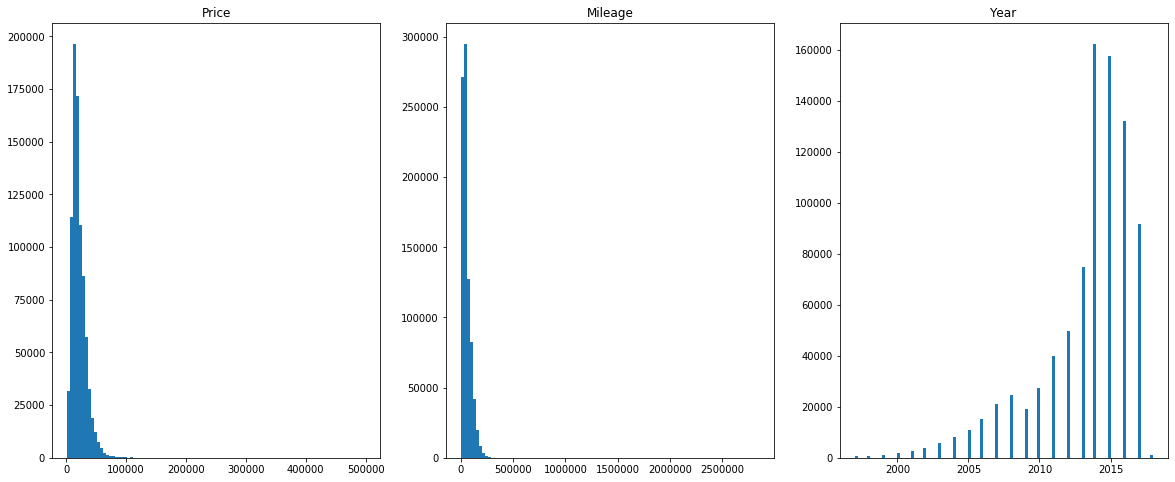

In [7]:
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.hist(df_raw['Price'], bins=100)
plt.title('Price')

plt.subplot(1, 3, 2)
plt.hist(df_raw['Mileage'], bins=100)
plt.title('Mileage')

plt.subplot(1, 3, 3)
plt.hist(df_raw['Year'], bins=100)
plt.title('Year')


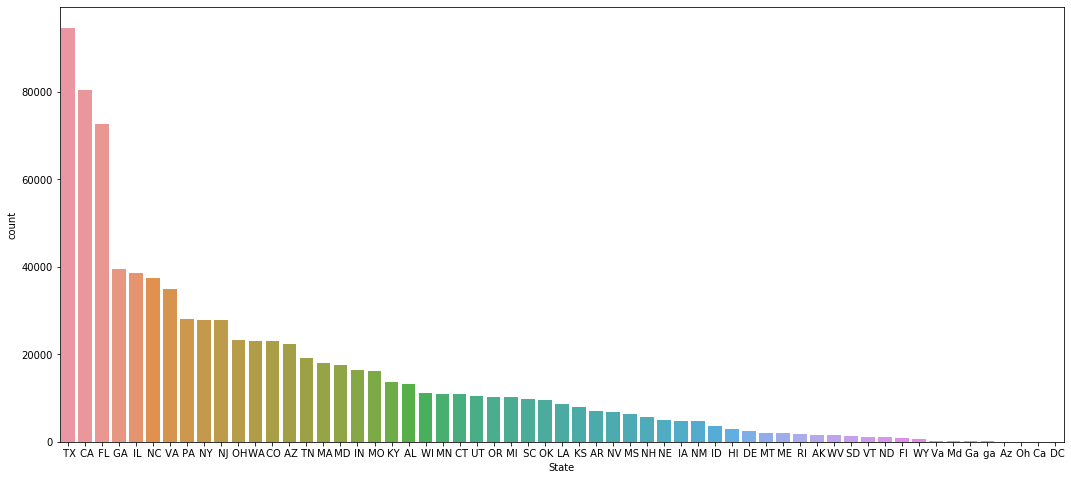

In [8]:
plt.figure(figsize=(18, 8))
sns.countplot(x=df_raw['State'], order=df_raw['State'].value_counts().index)

We see that there are outliers in data. Let's set up a constraint of 3 standard deviations for price and mileage.

In [9]:
from scipy import stats

std_dev = 3
df_clean = df_raw[(np.abs(stats.zscore(df_raw[['Price', 'Mileage']])) < float(std_dev)).all(axis=1)]

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833136 entries, 0 to 852120
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    833136 non-null  int64 
 1   Year     833136 non-null  int64 
 2   Mileage  833136 non-null  int64 
 3   City     833136 non-null  object
 4   State    833136 non-null  object
 5   Vin      833136 non-null  object
 6   Make     833136 non-null  object
 7   Model    833136 non-null  object
dtypes: int64(3), object(5)
memory usage: 57.2+ MB


Now let's check the data for missing values.

In [11]:
df_clean.isnull().values.any()

False

Let's check the distribution once again

Text(0.5, 1.0, 'Year')

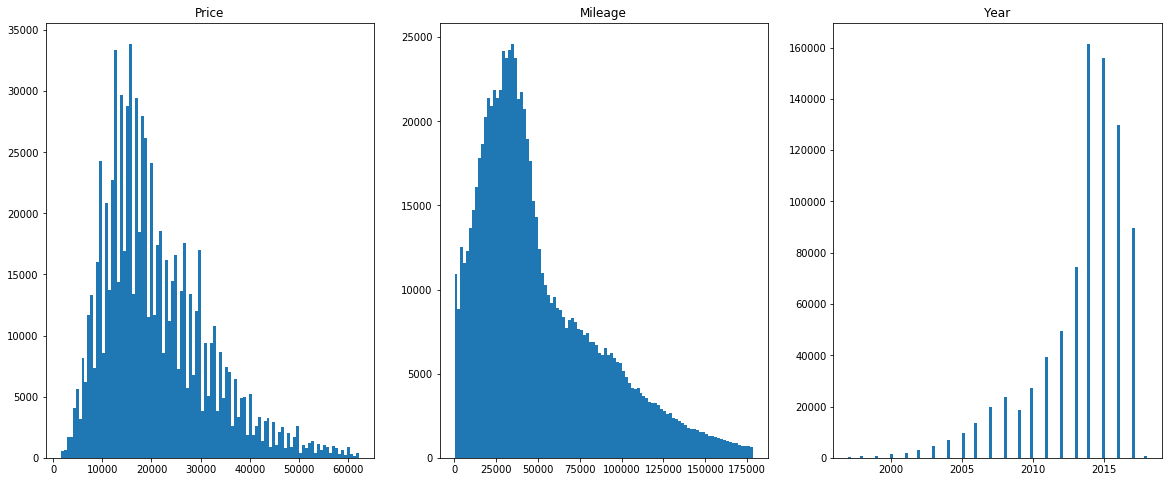

In [12]:
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.hist(df_clean['Price'], bins=100)
plt.title('Price')

plt.subplot(1, 3, 2)
plt.hist(df_clean['Mileage'], bins=100)
plt.title('Mileage')

plt.subplot(1, 3, 3)
plt.hist(df_clean['Year'], bins=100)
plt.title('Year')

Now the distribution looks much better. 

In [13]:
df_raw['City'].nunique()

2553

We have got 2553 unique cities, that's quite a lot. We need to encode it in some way so that does not affect training. To do this let's get population information for the cities from data.world and merge it to our dataframe.

In [14]:
us_cities = pd.read_excel('US City Populations.xlsx')
us_cities.drop('State', axis=1, inplace=True)
us_cities.sort_values('Population', ascending=False)
us_cities.head()

,City,Population
0,Abernant,7599
1,Alabaster,31545
2,Albertville,21458
3,Alexander City,14849
4,Andalusia,9081


In [15]:
us_cities.drop_duplicates(subset='City', keep='first', inplace=True)
us_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5603 entries, 0 to 6888
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        5603 non-null   object
 1   Population  5603 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 131.3+ KB


In [16]:
df_clean = df_clean.merge(us_cities, on='City', how='left')
df_clean.head()

,Price,Year,Mileage,City,State,Vin,Make,Model,Population
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed,679036.0
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed,NaN
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed,679036.0
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed,27414.0
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic,10723.0


In [17]:
df_clean.Population.isna().value_counts()

False    753071
True      80065
Name: Population, dtype: int64

In [18]:
df_clean.Population.fillna(df_clean['Population'].median(), inplace=True)

In [19]:
df_clean.Population.isna().value_counts()

False    833136
Name: Population, dtype: int64

Now let's encode the city column with 1 for city population more than 50000 and 0 for less 50000.

In [20]:
df_clean['City'] = np.where(df_clean['Population'] > 50000, 1, 0)
df_clean.drop(['Vin', 'Population'], axis=1, inplace=True)
df_clean.head()

,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,1,TX,Acura,ILX6-Speed
1,10888,2013,19606,0,NY,Acura,ILX5-Speed
2,8995,2013,48851,1,TX,Acura,ILX6-Speed
3,10999,2014,39922,0,CO,Acura,ILX5-Speed
4,14799,2016,22142,0,UT,Acura,ILXAutomatic


In [21]:
df_clean.head()

,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,1,TX,Acura,ILX6-Speed
1,10888,2013,19606,0,NY,Acura,ILX5-Speed
2,8995,2013,48851,1,TX,Acura,ILX6-Speed
3,10999,2014,39922,0,CO,Acura,ILX5-Speed
4,14799,2016,22142,0,UT,Acura,ILXAutomatic


Let's now look for some correlations between numeric variables. We would better take a particular model for that so not to get a mess. But first, we need to clean the names.

In [22]:
df_clean['State'] = df_clean['State'].str.lower()

In [23]:
df_clean['Make'] = df_clean['Make'].str.lower()

In [24]:
df_clean['Model'] = df_clean['Model'].str.lower()
df_clean['Model'] = df_clean['Model'].str.replace(' ', '')
df_clean['Model'] = df_clean['Model'].str.replace('-', '')

In [25]:
honda = df_clean[(df_clean.Make == 'honda') & (df_clean.Model == 'accord')]

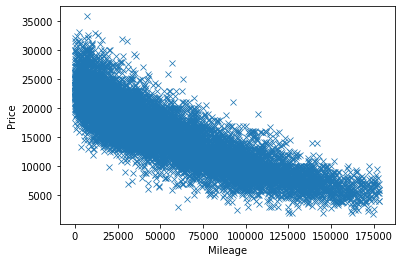

In [26]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Mileage', y='Price', data=honda, marker='x')

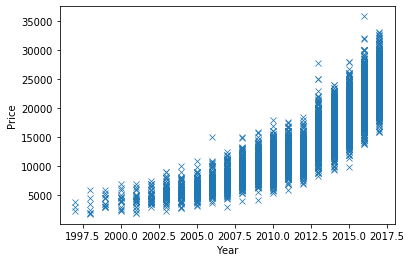

In [27]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Year', y='Price', data=honda, marker='x')

We see that linearity is quite obvious.

## Categorical data encoding and feature scaling

As we are going to use linear regression as the baseline we need to scale the numeric features and encode the categorical data (state, make and model).


There are a lot of unique rows in categorical features, so one-hot encoding will create a huge dataframe. So, we'd better clean out some rare cars. 

In [28]:
cars_drop = df_clean['Model'].value_counts()[171:]
df_clean.drop(df_clean[df_clean.Model.isin(cars_drop.index)].index, inplace=True)

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# splitting data into train and test sets
X = df_clean.drop('Price', axis=1)
y = df_clean['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train.loc[:, ['Year', 'Mileage']] = scaler.fit_transform(X_train.loc[:, ['Year', 'Mileage']])
X_test.loc[:, ['Year', 'Mileage']] = scaler.transform(X_test.loc[:, ['Year', 'Mileage']])

X_train.head()

,Year,Mileage,City,State,Make,Model
649038,0.445216,-0.847319,0,fl,nissan,roguesv
283755,0.445216,-0.836393,0,ga,ford,edgesel
684712,-2.629405,2.154146,1,wi,pontiac,grand
721666,0.103591,-0.107240,0,ma,subaru,forester2.5i
422258,1.128465,-0.111312,0,nc,hyundai,elantra4dr


In [35]:
column_trans = make_column_transformer((OneHotEncoder(), ['State', 'Make', 'Model']),
                                                remainder='passthrough')
        
X_train = column_trans.fit_transform(X_train)
X_test = column_trans.fit_transform(X_test)